In [10]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
# from keras.applications import DenseNet121
# from keras.callbacks import Callback, ModelCheckpoint
# from keras.models import Sequential
# from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [11]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [13]:
train_df = pd.read_csv('/Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train.csv')
print(train_df.shape)
train_df.head()

(3662, 2)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [16]:
def graham_method(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply edge enhancement using Laplacian filter
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    enhanced_edges = np.uint8(np.abs(laplacian))

    # Apply contrast enhancement using histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Combine enhanced edges and equalized image
    enhanced_image = cv2.addWeighted(equalized, 0.7, enhanced_edges, 0.3, 0)

    # Apply noise reduction using Gaussian blur
    denoised_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    return denoised_image

def process_images(input_directory, output_directory):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # List all files in the input directory
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for image_file in image_files:
        # Read the image
        input_path = os.path.join(input_directory, image_file)
        image = cv2.imread(input_path)

        # Apply Graham's method
        processed_image = graham_method(image)

        # Save the processed image to the output directory
        output_path = os.path.join(output_directory, image_file)
        cv2.imwrite(output_path, processed_image)

        print(f"Processed: {input_path} -> {output_path}")

input_directory = "/Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images"
output_directory = "/Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess"
process_images(input_directory, output_directory)

Processed: /Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images/46923eea9a4e.png -> /Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess/46923eea9a4e.png
Processed: /Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images/2d7666b8884f.png -> /Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess/2d7666b8884f.png
Processed: /Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images/419406328dcd.png -> /Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess/419406328dcd.png
Processed: /Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images/50840c36f0b4.png -> /Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess/50840c36f0b4.png
Processed: /Users/saurabhkumar/Desktop/MajorProject2/aptos2019-blindness-detection/train_images/c9ea9d5eab65.png -> /Users/saurabhkumar/Desktop/MajorProject2/Modelcode/preprocess/c9ea9d5eab65.png
Processed: /Users/sa

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

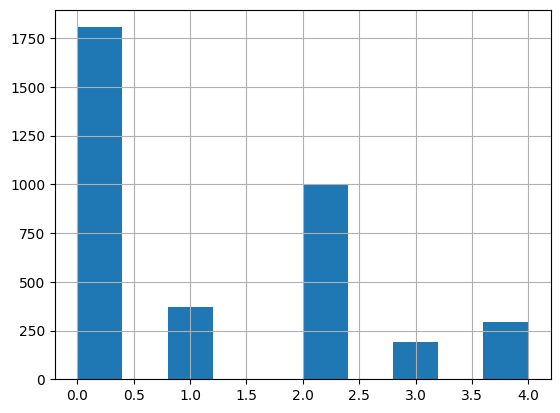

In [17]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

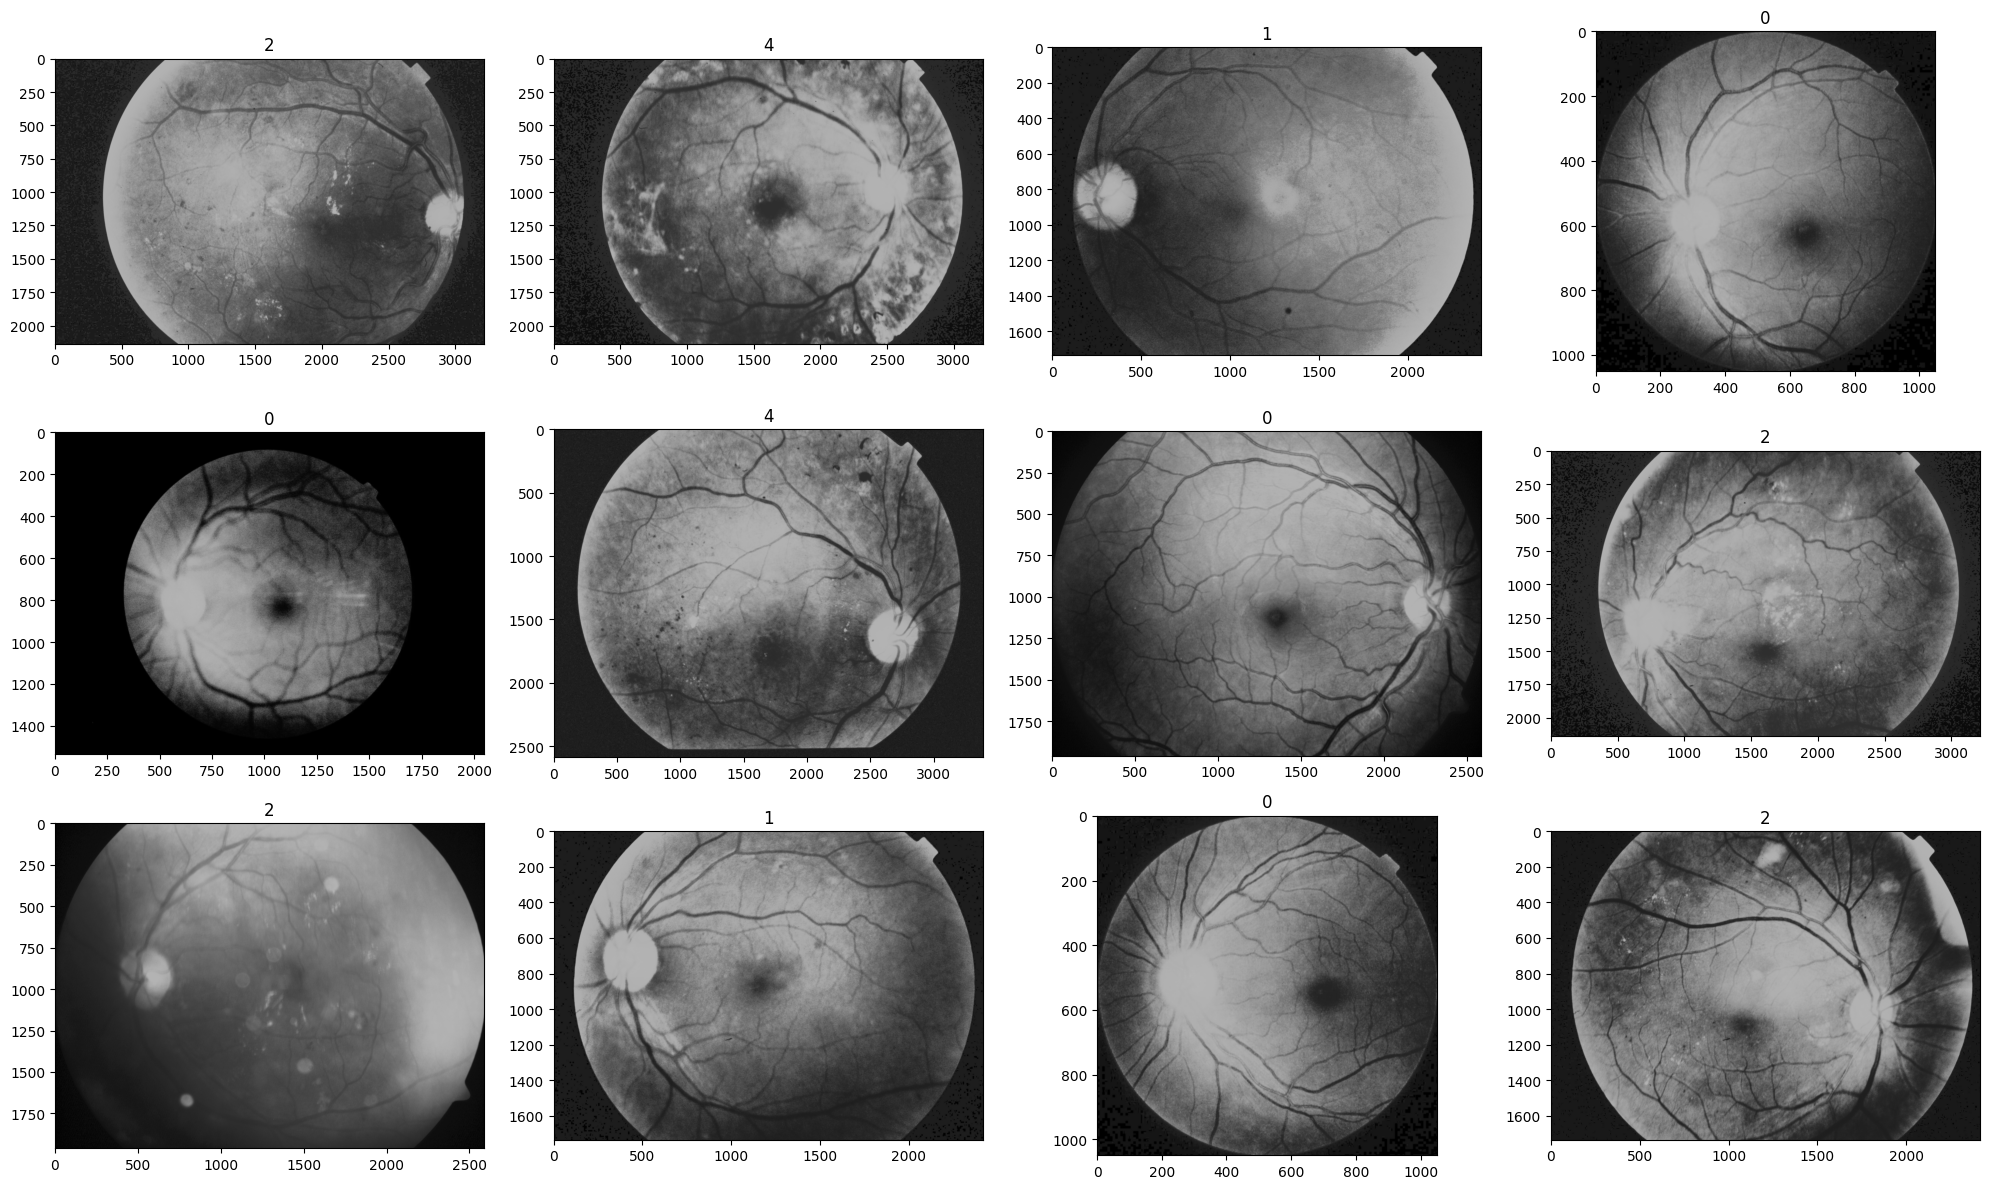

In [30]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/Users/saurabhkumar/Desktop/MajorProject2/ModelCode/preprocess/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [31]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [118]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/Users/saurabhkumar/Desktop/MajorProject2/ModelCode/preprocess/{image_id}.png'
    )

# # Assuming preprocess_image() loads a 2D grayscale image (224, 224)
# x_train = np.empty((N, 224, 224, 1), dtype=np.uint8)

# for i, image_id in enumerate(tqdm(train_df['id_code'])):
#     # Preprocess the image (returns (224, 224) - 2D array)
#     img = preprocess_image(f'/Users/saurabhkumar/Desktop/MajorProject2/ModelCode/preprocess/{image_id}.png')
    
#     # Add a channel dimension (turn (224, 224) into (224, 224, 1))
#     x_train[i, :, :, :] = np.expand_dims(img, axis=-1)  # This will convert it into (224, 224, 1)


  0%|                                                  | 0/3662 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [49]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)

(3662, 224, 224, 1)
(3662, 5)


In [50]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [51]:
y_train_multi = y_train_multi[:x_train.shape[0]]

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_train, y_train_multi, 
    test_size=0.2,
    random_state=2019
)

x_train_partial, x_val, y_train_partial, y_val = train_test_split(
    x_train_full, y_train_full, 
    test_size=0.1, 
    random_state=2019
)

In [54]:
# BATCH_SIZE = 32

# def create_datagen():
#     return ImageDataGenerator(
#         zoom_range=0.15, 
#         fill_mode='constant',
#         cval=0.,  
#         horizontal_flip=True,  
#         vertical_flip=True,  
#     )

# data_generator = create_datagen().flow(x_train_partial, y_train_partial, batch_size=BATCH_SIZE, seed=2019)
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# BATCH_SIZE = 32

# Ensure x_train_partial is 4D (num_samples, height, width, channels)
if x_train_partial.ndim == 3:  # If it's (num_samples, height, width)
    x_train_partial = np.expand_dims(x_train_partial, axis=-1)  # Add channel dimension -> (num_samples, height, width, 1)

# If it's grayscale, the above step should work. If it's RGB, ensure the shape is (num_samples, height, width, 3).

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,  
    )

# Create the data generator
data_generator = create_datagen().flow(x_train_partial, y_train_partial, batch_size=BATCH_SIZE, seed=2019)


In [55]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [58]:
densenet = DenseNet121(
    weights='/Users/saurabhkumar/Desktop/MajorProject2/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [61]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [62]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [112]:
print(x_train_rgb[:32].shape)  # Expected: (32, height, width, channels)
print(y_train[:32].shape)      # Expected: (32, number_of_classes)


(32, 224, 224, 3)
(32, 5)


In [113]:
# kappa_metrics = Metrics()

# history = model.fit_generator(
#     data_generator,
#     steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
#     epochs=20,
#     validation_data=(x_val, y_val),
#     callbacks=[kappa_metrics]
# )

kappa_metrics = Metrics()

history = model.fit(
    data_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)


Epoch 1/20
 83/114 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

TypeError: 'NoneType' object is not iterable

In [ ]:
model.save('densenet.keras')

In [89]:
y_pred = model.predict(x_test) > 0.5
y_pred = y_pred.astype(int).sum(axis=1) - 1
y_pred[0]

23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


0

In [90]:
# y_true[0]
# Assuming you have y_test as the true labels for testing data
y_true = y_test  # or y_val if you're using validation data

# Now you can access the first value in y_true
y_true[0]


array([ True, False, False, False, False])

In [91]:
y_true = y_test.sum(axis=1) - 1
y_true[0]

0

In [92]:
print(y_pred.shape)
print(y_true.shape)

(733,)
(733,)


In [93]:
# with open('history.json', 'w') as f:
#     json.dump(history.history, f)

# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()
# history_df[['acc', 'val_acc']].plot()

# Save the history to a JSON file
with open('history.json', 'w') as f:
    json.dump(history.history, f)

# Convert history to DataFrame and plot the loss and accuracy
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()  # Ensure you're using the correct keys for accuracy


NameError: name 'history' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_true, y_pred) 
print('Confusion matrix:')
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred) 
print('\nAccuracy : ', accuracy)

In [ ]:
macro_precision = precision_score(y_true, y_pred, average = 'macro') 
micro_precision = precision_score(y_true, y_pred, average = 'micro') 
weighted_precision = precision_score(y_true, y_pred, average = 'weighted') 

print('Macro Precision : ', macro_precision)
print('Micro Precision : ', micro_precision)
print('Weighted Precision : ', weighted_precision)

In [ ]:
macro_recall = recall_score(y_true, y_pred, average = 'macro') 
micro_recall = recall_score(y_true, y_pred, average = 'micro') 
weighted_recall = recall_score(y_true, y_pred, average = 'weighted') 

print('Macro recall : ', macro_recall)
print('Micro recall : ', micro_recall)
print('Weighted recall : ', weighted_recall)

In [ ]:
macro_f1 = f1_score(y_true, y_pred, average = 'macro') 
micro_f1 = f1_score(y_true, y_pred, average = 'micro') 
weighted_f1 = f1_score(y_true, y_pred, average = 'weighted') 

print('Macro f1 : ', macro_f1)
print('Micro f1 : ', micro_f1)
print('Weighted f1 : ', weighted_f1)